## Setup

**Note**: this currently requires this fork of transformers: https://github.com/huggingface/transformers/pull/25254

In [1]:
import jax

In [2]:
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 8 JAX devices of type TPU v2.


In [3]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionXLPipeline, FlaxStableDiffusionXLImg2ImgPipeline

In [4]:
from functools import partial

## Model Loading

We load the `base` and `refiner` models and reuse the params for identical models (`text_encoder_2`, `vae`)

In [5]:
dtype = jnp.bfloat16

In [6]:
# These weights are in float32
model_id = "pcuenq/stable-diffusion-xl-base-1.0-flax"

In [7]:
pipeline, params = FlaxStableDiffusionXLPipeline.from_pretrained(
    model_id,
    dtype=dtype,
    use_memory_efficient_attention=True,
)

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tcmalloc: large alloc 2778660864 bytes == 0x48d6c000 @  0x7fef29d50680 0x7fef29d71824 0x4d6a71 0x4ebb60 0x5a38b7 0x4fb465 0x61cbd1 0x5a3469 0x50a165 0x4ee071 0x5090de 0x4eecf3 0x5090de 0x4eecf3 0x595062 0x594fa7 0x59c49d 0x4fdaf4 0x4edc5f 0x59eab9 0x4ef4a7 0x59eab9 0x4ef4a7 0x59eab9 0x5b2c46 0x507f8f 0x4ee071 0x4fd90f 0x4edc5f 0x4fd90f 0x4ee071
The config attributes {'interpolation_type': 'linear', 'timestep_spacing': 'leading', 'use_karras_sigmas': False} were passed to FlaxDPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
/home/pedro/code/diffusers/src/diffusers/configuration_utils.py:217: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from

`params` are still in `float32` despite the `dtype`. This won't be the case after we merge  https://github.com/huggingface/diffusers/pull/4172. Let's convert them.

In [8]:
params = jax.tree_util.tree_map(lambda x: x.astype(dtype), params)

## Inference

Things I tried:
- Base pipeline works if we return `latents` and don't use the VAE.
- Removing the decoder does not work.
- Memory efficient attention does not help (it only affects the UNet).
- Running computation in `bfloat16` does not help either.

I verified that the base pipeline works if we return `latents` (we don't use the VAE). And we don't use the refiner. Let's try to do the following:
- Put the text encoders in device 0.
- Put the base UNet in devices 1, 2, 3
- Put the refiner UNet in devices 4, 5, 6
- Put the VAE decoder in device 7.

This would give 3 images per prompt but we'll have a lot of memory copies.

Can we make this work?

### VAE -> device 7

Let's start with the VAE in a single device and see how many images it can process at once.

In [9]:
devices = jax.devices()

In [10]:
del params["vae"]["encoder"]

In [11]:
decoder_params = params["vae"]

In [12]:
decoder_devices = devices[7:]
ds = len(decoder_devices)

In [13]:
decoder_params = replicate(decoder_params, devices=decoder_devices)

In [14]:
rng = jax.random.PRNGKey(0)

By default, `latents` are generated in `float32`

In [15]:
bs = 2

In [16]:
latents = jax.random.normal(rng, (ds, bs, 4, 128, 128), dtype=jnp.float32)
# latents = jax.device_put(latents, decoder_devices)
latents.shape

(1, 2, 4, 128, 128)

I guess if it works in a single device then we could make it work with just `jit`, but `pmap` is easy.

In [17]:
@partial(jax.pmap, devices=decoder_devices)
def decode(latents, params):
    print(latents.shape)
    decoded = pipeline.vae.apply({"params": params}, latents, method=pipeline.vae.decode).sample
    return decoded

In [18]:
x = decode(latents, decoder_params)
x.shape

(2, 4, 128, 128)


(1, 2, 3, 1024, 1024)

I verified that a single device is able to decode `2` images, but OOMs with `3`. Let's go with this for now and we'll see if we parallelize them later.

### Text Encoders -> device 0

In [19]:
te_devices = devices[:1]
ts = len(te_devices)

In [20]:
te_params = {
    "text_encoder": params["text_encoder"],
    "text_encoder_2": params["text_encoder_2"],
}

In [21]:
te_params = replicate(te_params, devices=te_devices)

In [22]:
imgs_per_device = 1

In [23]:
prompt = "Labrador in the style of Vermeer"
# prompt = "photo of a rhino dressed suit and tie sitting at a table in a bar with a bar stools, award winning photography, Elke vogelsang"
prompt = [prompt] * imgs_per_device
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids.shape

(1, 2, 77)

In [24]:
neg_prompt = "ugly, saturated, bad quality, malformed"
# neg_prompt = "fog, grainy, purple"
neg_prompt = [neg_prompt] * imgs_per_device
neg_prompt_ids = pipeline.prepare_inputs(neg_prompt)
neg_prompt_ids.shape

(1, 2, 77)

In [25]:
prompt_ids = jax.device_put_replicated(prompt_ids, te_devices)
neg_prompt_ids = jax.device_put_replicated(neg_prompt_ids, te_devices)
prompt_ids.shape

(1, 1, 2, 77)

In [26]:
@partial(jax.pmap, devices=te_devices)
def get_embeddings(prompt_ids, params):
    # bs, encoder_input, seq_length
    te_1_inputs = prompt_ids[:, 0, :]
    te_2_inputs = prompt_ids[:, 1, :]

    prompt_embeds = pipeline.text_encoder(te_1_inputs, params=params["text_encoder"], output_hidden_states=True)
    prompt_embeds = prompt_embeds["hidden_states"][-2]
    prompt_embeds_2_out = pipeline.text_encoder_2(
        te_2_inputs, params=params["text_encoder_2"], output_hidden_states=True
    )
    prompt_embeds_2 = prompt_embeds_2_out["hidden_states"][-2]
    text_embeds = prompt_embeds_2_out["text_embeds"]
    prompt_embeds = jnp.concatenate([prompt_embeds, prompt_embeds_2], axis=-1)
    return prompt_embeds, text_embeds

In [27]:
prompt_embeds, pooled_embeds = get_embeddings(prompt_ids, te_params)

In [28]:
neg_prompt_embeds, neg_pooled_embeds = get_embeddings(neg_prompt_ids, te_params)

### Denoising loop -> devices [1, 2]

In [29]:
unet_devices = devices[1:3]
us = len(unet_devices)
us

2

In [30]:
unet_params = {
    "scheduler": params["scheduler"],
    "unet": params["unet"],
}
unet_params = replicate(unet_params, devices=unet_devices)

Replicate the embeddings for all the devices

In [31]:
prompt_embeds.shape

(1, 1, 77, 2048)

In [32]:
prompt_embeds = jax.device_put_replicated(prompt_embeds[0], unet_devices)
prompt_embeds.shape  #2, 1, 77, 2048

(2, 1, 77, 2048)

In [33]:
pooled_embeds = jax.device_put_replicated(pooled_embeds[0], unet_devices)
neg_prompt_embeds = jax.device_put_replicated(neg_prompt_embeds[0], unet_devices)
neg_pooled_embeds = jax.device_put_replicated(neg_pooled_embeds[0], unet_devices)

In [34]:
guidance_scale = jax.device_put_replicated(jnp.array([7.5]), unet_devices)
seed = jax.random.split(rng, us)
num_inference_steps = 20

Generate function that returns latents:

In [35]:
@partial(
    jax.pmap,
    in_axes=(None, 0, 0, 0, 0, 0, 0, 0, None),
    static_broadcasted_argnums=(0, 8),
    devices=unet_devices,
)
def generate(
    pipeline,
    prompt_embeds,
    pooled_embeds,
    neg_prompt_embeds,
    neg_pooled_embeds,
    params,
    prng_seed,
    guidance_scale: float,
    num_inference_steps: int,
):
    height = 1024
    width = 1024
    batch_size = prompt_embeds.shape[0]
    
    add_time_ids = pipeline._get_add_time_ids(
        (1024, 1024), (0, 0), (1024, 1024), batch_size, dtype=prompt_embeds.dtype
    )

    prompt_embeds = jnp.concatenate([neg_prompt_embeds, prompt_embeds], axis=0)
    add_text_embeds = jnp.concatenate([neg_pooled_embeds, pooled_embeds], axis=0)
    add_time_ids = jnp.concatenate([add_time_ids, add_time_ids], axis=0)

    # Create random latents
    latents_shape = (
        batch_size,
        pipeline.unet.config.in_channels,
        height // pipeline.vae_scale_factor,
        width // pipeline.vae_scale_factor,
    )
    latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)

    # scale the initial noise by the standard deviation required by the scheduler
    latents = latents * params["scheduler"].init_noise_sigma

    # Prepare scheduler state
    scheduler_state = pipeline.scheduler.set_timesteps(
        params["scheduler"], num_inference_steps=num_inference_steps, shape=latents.shape
    )

    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

    # Denoising loop
    def loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = pipeline.scheduler.scale_model_input(scheduler_state, latents_input, t)

        # predict the noise residual
        noise_pred = pipeline.unet.apply(
            {"params": params["unet"]},
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = pipeline.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state

    latents, _ = jax.lax.fori_loop(0, num_inference_steps, loop_body, (latents, scheduler_state))
    return latents

In [36]:
latents = generate(
    pipeline,
    prompt_embeds,
    pooled_embeds,
    neg_prompt_embeds,
    neg_pooled_embeds,
    unet_params,
    seed,
    guidance_scale,
    num_inference_steps,
)

In [37]:
latents.shape

(2, 1, 4, 128, 128)

In [38]:
def decode_latents(latents):
    latents = latents.transpose(1, 0, 2, 3, 4)
    latents = 1 / pipeline.vae.config.scaling_factor * latents
    images = decode(latents, decoder_params)
    images = images.reshape((images.shape[0] * images.shape[1], ) + images.shape[-3:])
    images = (images / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    images = pipeline.numpy_to_pil(np.array(images))
    return images

In [39]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

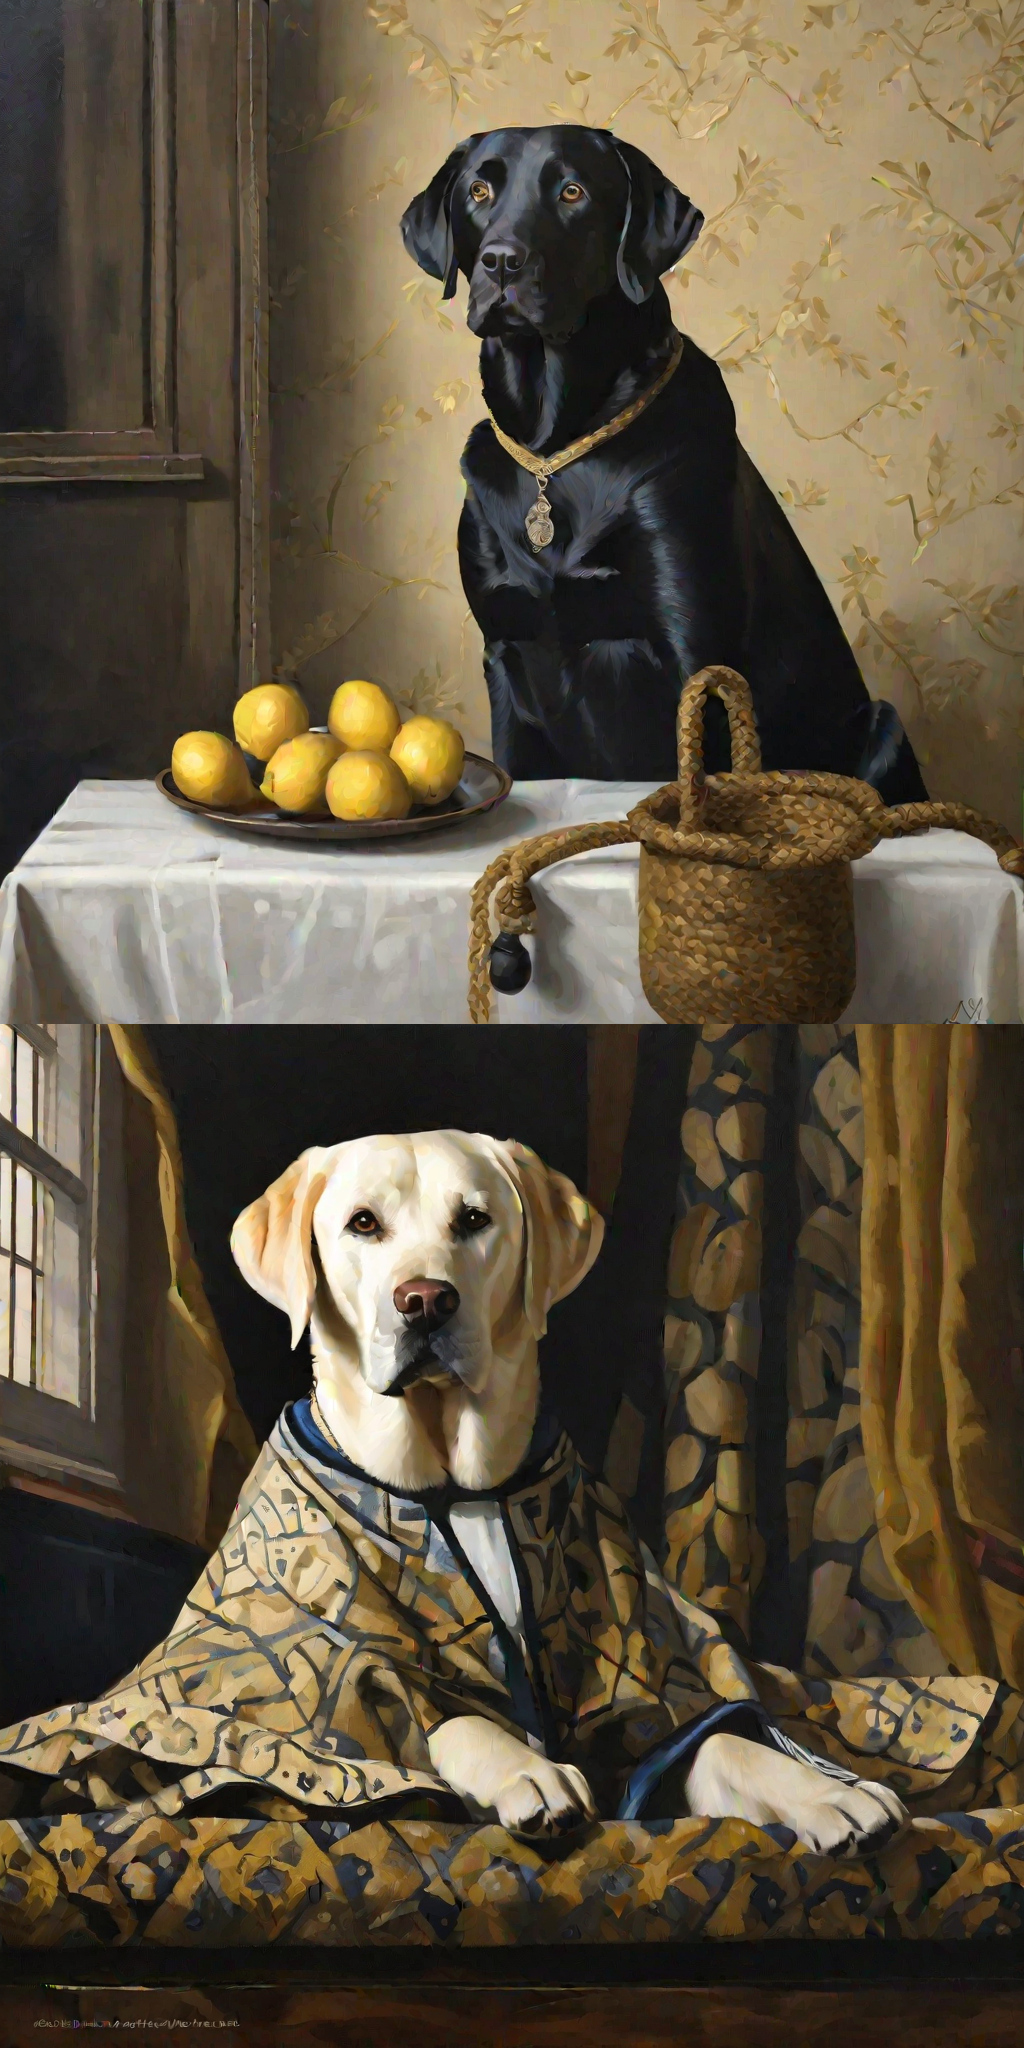

In [40]:
images = decode_latents(latents)
image_grid(images, 2, len(images)//2)

**So cool!** Let's try to see if we can fit the refiner in the other devices.

## Refiner

In [41]:
from diffusers import FlaxStableDiffusionXLImg2ImgPipeline

refiner, refiner_params = FlaxStableDiffusionXLImg2ImgPipeline.from_pretrained(
    "pcuenq/stable-diffusion-xl-refiner-1.0-flax",
    text_encoder=None,
    text_encoder_2=None,
    vae=pipeline.vae,
    dtype=dtype,
)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

The config attributes {'force_zeros_for_empty_prompt': False, 'text_encoder': [None, None], 'tokenizer': [None, None]} were passed to FlaxStableDiffusionXLImg2ImgPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'force_zeros_for_empty_prompt': False, 'text_encoder': None, 'tokenizer': [None, None]} are not expected by FlaxStableDiffusionXLImg2ImgPipeline and will be ignored.
The config attributes {'interpolation_type': 'linear', 'timestep_spacing': 'leading', 'use_karras_sigmas': False} were passed to FlaxDPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
The config attributes {'act_fn': 'silu', 'center_input_sample': False, 'class_embed_type': None, 'class_embeddings_concat': False, 'conv_in_kernel': 3, 'conv_out_kernel': 3, 'cross_attention_norm': None, 'downsample_padding': 1, 'dual_cross_attention': False, 'encoder_hid_dim': N

In [42]:
refiner_params = jax.tree_util.tree_map(lambda x: x.astype(dtype), refiner_params)

In [43]:
refiner_devices = devices[3:5]
rs = len(refiner_devices)
rs

2

In [44]:
refiner_params = replicate(refiner_params, devices=refiner_devices)

Replicate the embeddings for all the devices. I'll use the same prompts as before, this would be the place where different prompts could be used. Note we use the base pipeline because that's where the text encoder is.

In [45]:
prompt_ids.shape

(1, 1, 2, 77)

In [46]:
prompt_ids = refiner.prepare_text_inputs(prompt)
neg_prompt_ids = refiner.prepare_text_inputs(neg_prompt)
prompt_ids.shape

(1, 1, 77)

In [47]:
prompt_ids = jax.device_put_replicated(prompt_ids, te_devices)
neg_prompt_ids = jax.device_put_replicated(neg_prompt_ids, te_devices)
prompt_ids.shape

(1, 1, 1, 77)

In [48]:
@partial(jax.pmap, devices=te_devices)
def get_refiner_embeddings(prompt_ids, params):
    # bs, encoder_input, seq_length
    # Extract ids from tokenizer_2. Careful if we tokenize again.
    te_inputs = prompt_ids[:, 0, :]

    prompt_embeds_2_out = pipeline.text_encoder_2(
        te_inputs, params=params["text_encoder_2"], output_hidden_states=True
    )
    text_embeds = prompt_embeds_2_out["text_embeds"]
    prompt_embeds = prompt_embeds_2_out["hidden_states"][-2]
    return prompt_embeds, text_embeds

In [49]:
prompt_embeds, pooled_embeds = get_refiner_embeddings(prompt_ids, te_params)

In [50]:
neg_prompt_embeds, neg_pooled_embeds = get_refiner_embeddings(neg_prompt_ids, te_params)

In [51]:
prompt_embeds.shape

(1, 1, 77, 1280)

In [52]:
prompt_embeds = jax.device_put_replicated(prompt_embeds[0], refiner_devices)
prompt_embeds.shape  #2, 1, 77, 1280

(2, 1, 77, 1280)

In [53]:
pooled_embeds = jax.device_put_replicated(pooled_embeds[0], refiner_devices)
neg_prompt_embeds = jax.device_put_replicated(neg_prompt_embeds[0], refiner_devices)
neg_pooled_embeds = jax.device_put_replicated(neg_pooled_embeds[0], refiner_devices)

In [54]:
aesthetic_score = 6.0
negative_aesthetic_score = 2.5

strength = 0.3
start_timestep = refiner.get_timestep_start(num_inference_steps, strength)

Generate function that returns latents:

In [55]:
def _get_add_time_ids(
    original_size, crops_coords_top_left, target_size, aesthetic_score, negative_aesthetic_score, bs, dtype
):
    add_time_ids = list(original_size + crops_coords_top_left + (aesthetic_score,))
    add_neg_time_ids = list(original_size + crops_coords_top_left + (negative_aesthetic_score,))

    add_time_ids = jnp.array([add_time_ids] * bs, dtype=dtype)
    add_neg_time_ids = jnp.array([add_neg_time_ids] * bs, dtype=dtype)

    return add_time_ids, add_neg_time_ids

In [56]:
@partial(
    jax.pmap,
    in_axes=(None, 0, 0, 0, 0, 0, 0, 0, 0, None, None, None, None),
    static_broadcasted_argnums=(0, 9, 10, 11, 12),
    devices=refiner_devices,
)
def refiner_generate(
    pipeline,
    image,
    prompt_embeds,
    pooled_embeds,
    neg_prompt_embeds,
    neg_pooled_embeds,
    params,
    prng_seed,
    guidance_scale: float,
    start_timestep: int,
    num_inference_steps: int,
    aesthetic_score: float,
    negative_aesthetic_score: float,
):
    height = 1024
    width = 1024
    batch_size = prompt_embeds.shape[0]
    
    add_time_ids, add_neg_time_ids = _get_add_time_ids(
        (1024, 1024),
        (0, 0),
        (1024, 1024),
        aesthetic_score,
        negative_aesthetic_score,
        batch_size,
        dtype=prompt_embeds.dtype,
    )

    prompt_embeds = jnp.concatenate([neg_prompt_embeds, prompt_embeds], axis=0)
    add_text_embeds = jnp.concatenate([neg_pooled_embeds, pooled_embeds], axis=0)
    add_time_ids = jnp.concatenate([add_neg_time_ids, add_time_ids], axis=0)

    # Create random latents
    latents_shape = (
        batch_size,
        pipeline.unet.config.in_channels,
        height // pipeline.vae_scale_factor,
        width // pipeline.vae_scale_factor,
    )
    noise = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)

    assert image.shape[1] == 4
    init_latents = image

    # Prepare scheduler state
    scheduler_state = pipeline.scheduler.set_timesteps(
        params["scheduler"], num_inference_steps=num_inference_steps, shape=latents_shape
    )

    latent_timestep = scheduler_state.timesteps[start_timestep : start_timestep + 1].repeat(batch_size)
    latents = pipeline.scheduler.add_noise(params["scheduler"], init_latents, noise, latent_timestep)

    # scale the initial noise by the standard deviation required by the scheduler
    latents = latents * params["scheduler"].init_noise_sigma

    # Ensure model output will be `float32` before going into the scheduler
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)

    added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}

    # Denoising loop
    def loop_body(step, args):
        latents, scheduler_state = args
        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        latents_input = jnp.concatenate([latents] * 2)

        t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
        timestep = jnp.broadcast_to(t, latents_input.shape[0])

        latents_input = pipeline.scheduler.scale_model_input(scheduler_state, latents_input, t)

        # predict the noise residual
        noise_pred = pipeline.unet.apply(
            {"params": params["unet"]},
            jnp.array(latents_input),
            jnp.array(timestep, dtype=jnp.int32),
            encoder_hidden_states=prompt_embeds,
            added_cond_kwargs=added_cond_kwargs,
        ).sample
        # perform guidance
        noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents, scheduler_state = pipeline.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
        return latents, scheduler_state

    latents, _ = jax.lax.fori_loop(start_timestep, num_inference_steps, loop_body, (latents, scheduler_state))
    return latents

In [57]:
latents.shape

(2, 1, 4, 128, 128)

In [58]:
pooled_embeds.shape

(2, 1, 1280)

In [59]:
refined = refiner_generate(
    refiner,
    latents,
    prompt_embeds,
    pooled_embeds,
    neg_prompt_embeds,
    neg_pooled_embeds,
    refiner_params,
    seed,
    guidance_scale,
    start_timestep,
    num_inference_steps,
    aesthetic_score,
    negative_aesthetic_score,
)

In [60]:
refined.shape

(2, 1, 4, 128, 128)

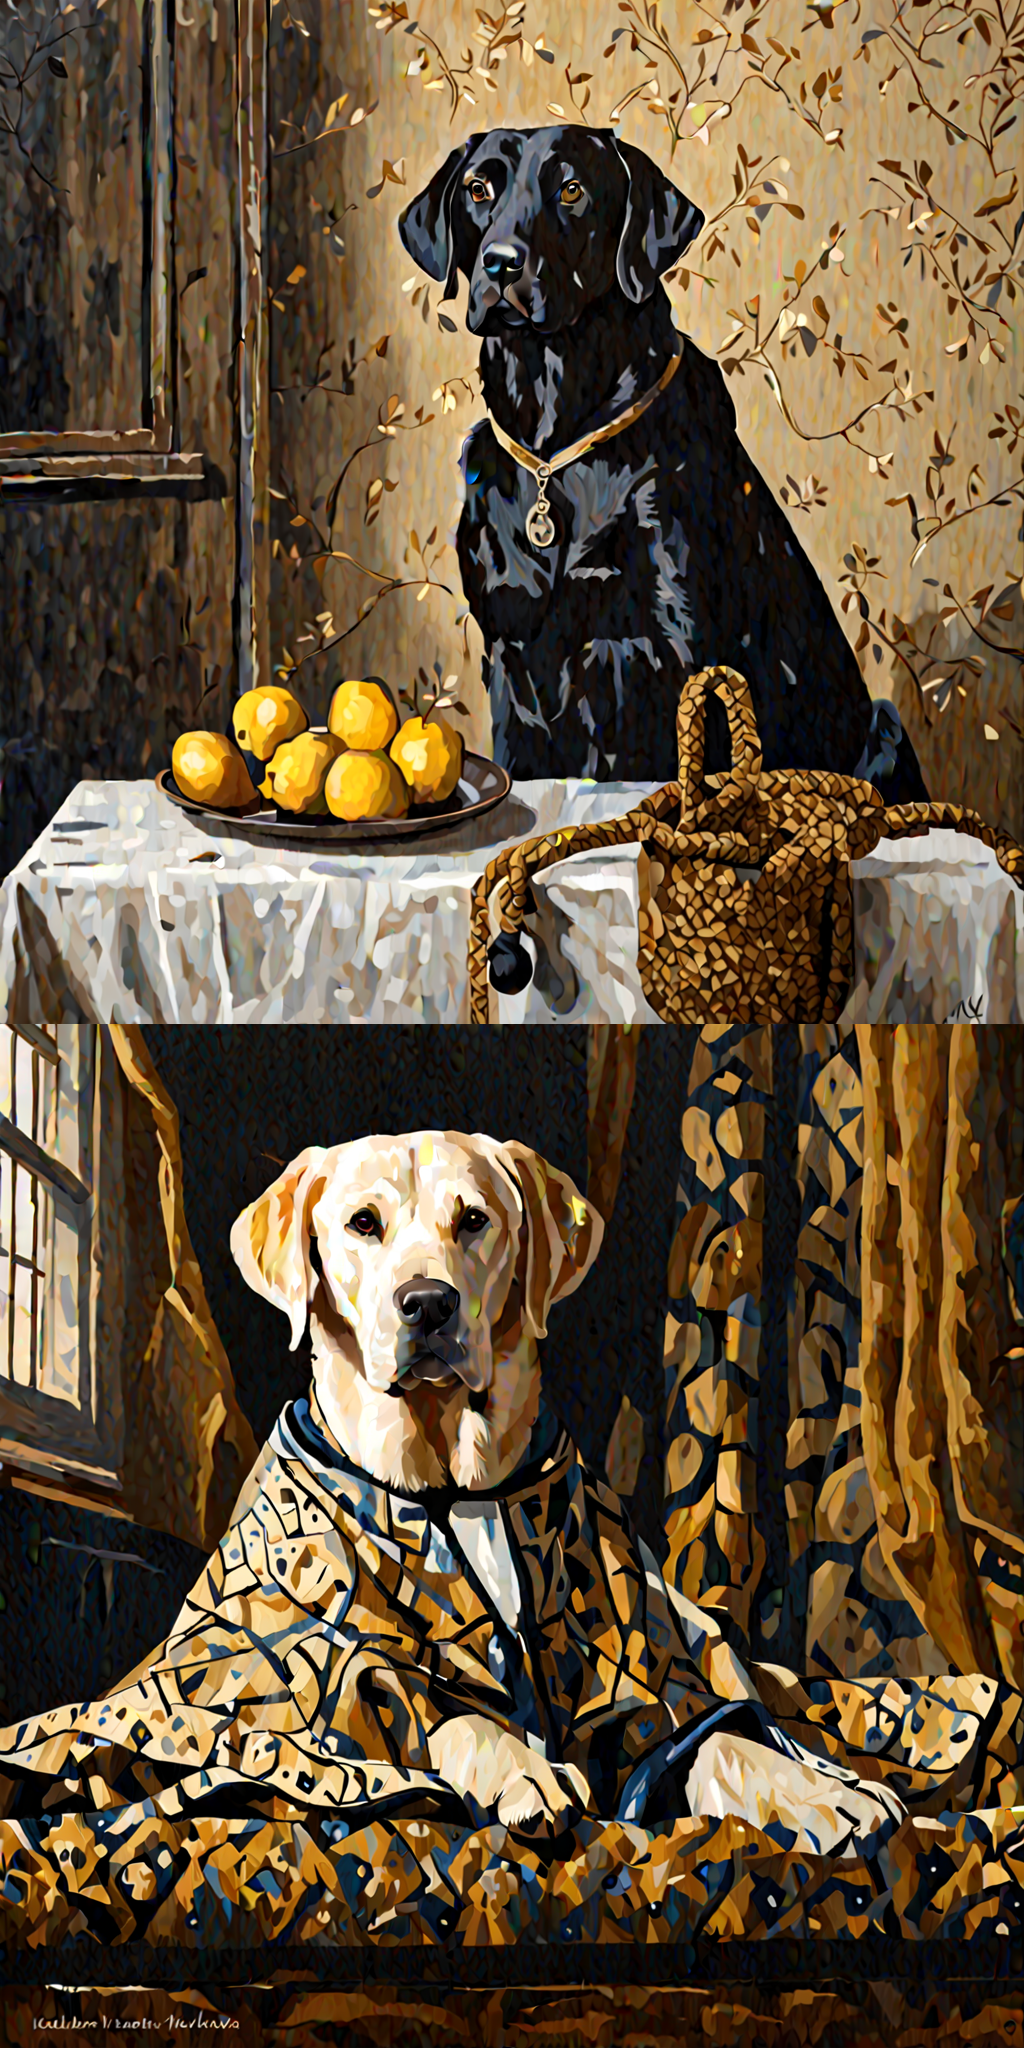

In [61]:
images = decode_latents(refined)
image_grid(images, 2, len(images)//2)